# Import Libraries and Load Data

In [1]:
# Data visualisations
import matplotlib.pyplot as plt

# Base libraries
import numpy as np
import pandas as pd

# More data viz
import plotly.express as px
import seaborn as sns

# to use pandas dtypes in matplotlib plots
from pandas.plotting import register_matplotlib_converters

# rich
from rich.console import Console

# define rich console for formatted output
console = Console()

# have pandas types plotted with matplotlib
register_matplotlib_converters()

# set plotly as backend for plots wih pandas
pd.options.plotting.backend = "plotly"

# create a dict to update plotly layout
plotly_styles = dict(
    font_family="DejaVuSansMono Nerd Font",
    template="none",
    title={
        "x": 0.05,
        # basically, what part of the title to put at position "x"
        "xanchor": "left",
    },
)


# set settings for seaborn
sns.set_style(style="darkgrid", rc={"axes.facecolor": ".9", "grid.color": ".8"})
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")  # will be useful later

# visualise plots inline
%matplotlib inline

# customise matplotlib and sns plot dimensions
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100

We use `squeeze=True` to indicate that our data has only one column and we want to retrieve a `pandas.Series` (see [here](https://machinelearningmastery.com/load-explore-time-series-data-python/))

In [2]:
daily_rentals = pd.read_csv(
    "../data/bikemi_csv/daily_outflow.csv",
    index_col=[0],
    parse_dates=[0],
    squeeze=True
).asfreq(freq="D") # set frequency

print(f"Our data is a {type(daily_rentals)}")

daily_rentals

Our data is a <class 'pandas.core.series.Series'>


giorno_partenza
2019-01-01     831
2019-01-02    3512
2019-01-03    4126
2019-01-04    4201
2019-01-05    2875
              ... 
2019-12-27    2995
2019-12-28    1944
2019-12-29    1269
2019-12-30    2698
2019-12-31    2126
Freq: D, Name: count, Length: 365, dtype: int64

We also need to make sure our index has a frequency - which we did with `.asfreq("D")` above:

In [3]:
daily_rentals.index

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='giorno_partenza', length=365, freq='D')

# Naïve forecaster

We need to fit a naïve forecaster to have a benchmark for our other methods:

In [4]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

We will be using a Seasonal Naive Forecaster (link Hyndman) where the predicted value is the one of the last seasonal value (i.e., 7 days before):

In [7]:
y_train, y_test = temporal_train_test_split(daily_rentals)

# uses all of the test set as forecasting horizon
fh = ForecastingHorizon(y_test.index, is_relative=False)

# naive forecaster model definition
naive_forecaster = NaiveForecaster(strategy="last", sp=7)  # weekly seasonal periodicity

# naive forecaster model fitting
naive_forecaster.fit(y_train)

# naive forecaster predictions
y_pred = naive_forecaster.predict(fh)

# naive forecaster error
naive_error = mean_absolute_percentage_error(y_test, y_pred)

print(naive_error)

0.6406029062204276


/Users/luca/.pyenv/versions/miniconda3-latest/envs/bikemi/lib/python3.8/site-packages/sktime/forecasting/base/_fh.py:451: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
/Users/luca/.pyenv/versions/miniconda3-latest/envs/bikemi/lib/python3.8/site-packages/sktime/forecasting/base/_fh.py:461: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
/Users/luca/.pyenv/versions/miniconda3-latest/envs/bikemi/lib/python3.8/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/Users/luca/.pyenv/versions/miniconda3-latest/envs/bikemi/lib/python3.8/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr
/Users/luca/.pyenv/vers

Our model has 64% MAPE - whereas one might have expected something more. Let's plot it to see the differences:

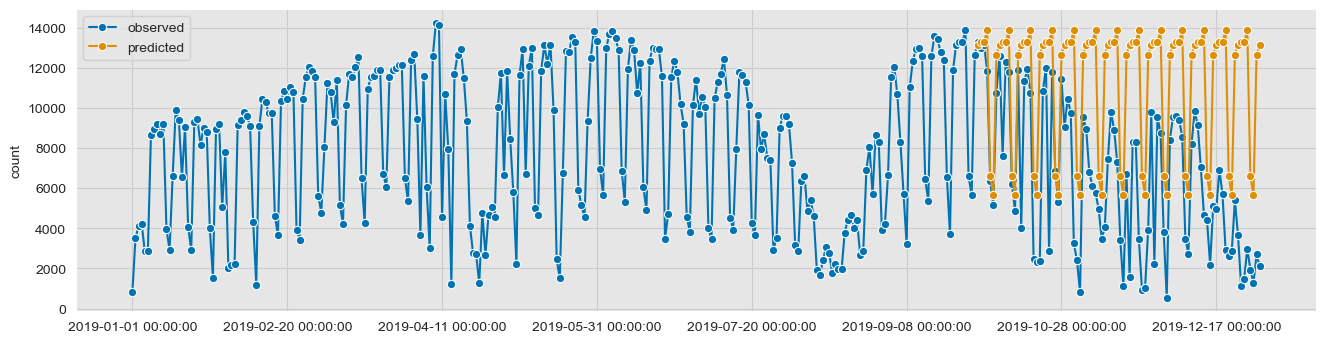

In [6]:
from sktime.utils.plotting import plot_series

plot_series(daily_rentals, y_pred, labels=["observed", "predicted"]);

# ARIMA Model

The autocorrelation plot suggested us to 